### Your name:

<pre> Craig Barbisan</pre>

### Collaborators:

<pre> N/A</pre>


In [1]:
import numpy as np
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(123)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

### Classification

Q1. Build a classification model for the default of credit card clients dataset. More info here:
https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

- Explore the data
- Make sure you build a full data pipeline
- Do you require any data pre-processing? Are all the features useful? (Use only raw features)
- set the random seed to 123 (For splitting or any other random algorithm)
- Split data into training (80%) and testing (20%)
- Follow similar procedure as the one for week 2 (End-to-end Machine Learning Project). Remember apendix B
- Study the ROC Curve, decide threshold
- Use 2 classifiers.
    - Random Forest
        - tune only: n_estimators: {3, 4, 6, 7, 10, 20, 50, 100} 
    - KNN Classfier 
        - tune only: n_neighbors: {3, 4, 5, 7, 10, 20, 50} 
    - Which one performs better in the cross validation?
    
http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

- Cross-validation with 4-folds.

- Other paramenters -> Use default

Notes:
  - Make your code modular, the second part of the assignmet you will have to repeat. 
  - Include documentation for your code 

# Frame the Problem

The objective, in business terms, is to predict when a credit-card customer will default on their payments in the upcoming month. Since this is an academic exercise, there is no actual business purpose being proposed for this model. However, we have been asked to compare performance of 2 different classifiers, Random Forest and kNN, so that could be practically viewed as the purpose of the model.

Our data set contains the label we are tyring to predict (default payment next month) which implies it will use supervised learning. The training of this model will be offline (batch), as we have a finite amount of data to train the system which will comfortably fit in the machine's memory, so there is no need to train the system incrementally. Our system will work by detecting patterns in the training data and building a predictive model accordingly. So in summary, our system will be an offline, model based, supervised learning system.

Performance of our model will be measured using ROC AUC score, which is a convenient single metric for comparing the performance of two models. Since our business objective is to predict credit default, which is a binary outcome (defaulted or not), then ROC AUC score aligns with that objective. The higher the AUC, the better the model is at predicting outcomes. An AUC of 0.5 means the model has no ability to distinguish between classes, so from a performance perspective, we would want AUC to be greater than 0.5 at a minimum.

# Get the Data

The data we have been directed to use, is the "default of credit card clients" data set from the UCI Machine Learning Repository, which can be found here:

https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

This data set is approximately 5.5 MB in size. UCI has made this data set freely available but requests that any material based on their data sets acknowledges their assistance. The citation policy can be found here:
https://archive.ics.uci.edu/ml/citation_policy.html

Additionally, the particular author of the study that produced this data set also requires citations be made as follows:

Yeh, I. C., & Lien, C. H. (2009). The comparisons of data mining techniques for the predictive accuracy of probability of default of credit card clients. Expert Systems with Applications, 36(2), 2473-2480.

The workspace used was my personal laptop running Anaconda, which includes the Jupyter Notebook component. The data has been downloaded from UCI in MS Excel (.xls) format, which is directly usable by the pandas API, so no conversion is required. There is no sensitive (i.e. personally identifiable information) data in the data set, so no filtering or anonimization is required. We will start with exploratory data analysis (EDA) by loading the data set into a pandas dataframe so we can start to explore and understand the data better. 


In [2]:
### Your code here

## Feel free to use multiple cells

df = pd.read_excel("https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls", 
                   sheet = 0, skiprows= 1, header = 0)

# Set aside the test data so we're not looking at it when we explore the data
# We can drop the ID column, which is an arbitrary value and will hold no significance to the model
from sklearn.model_selection import train_test_split
train, test = train_test_split(df.drop(["ID"], axis=1), test_size=0.2, random_state=123, stratify=df.SEX)

# Explore the Data

The following data dictionary was inferred from information provided on the UCI website:

<pre>
LIMIT_BAL - Credit limit on card
SEX - 1 = Male, 2 = Female
EDUCATION - 1 = Grad School, 2 = University, 3 = High School, 4 = Other
MARRIAGE - 1 = Married, 2 = Single, 3 = Other
AGE - Borrower's age in years
PAY_n - The repayment status as of n months prior to September 2005. Status values are number of months payment has been delayed. -1 means payments are up to date.
BILL_AMT_n - Balance showing on bill statement, in NT$, n-1 months prior to September 2005.
PAY_AMT_n - Payment made, in NT$, n-1 months prior to September 2005.
</pre>

The size of this data set (30,000 instances) is perfectly manageable, so there is no need to sample it down. Let's look at a few different views of the data, to give us a better understanding of the values we're working with:

In [3]:
# Need to set this option to ensure all columns are displayed
pd.options.display.max_columns = None
train.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
9424,60000,2,1,2,31,0,0,0,0,2,0,32632,34099,35525,38820,38066,39681,2000,2000,3900,0,2400,1500,1
5015,290000,2,1,2,24,1,-2,-2,-1,0,-1,0,0,0,2700,1350,1350,0,0,2700,0,1350,8334,0
4170,140000,1,1,2,27,-1,-1,-1,-1,-1,-1,13497,15680,3400,3218,16478,4078,15688,4000,3218,17000,4500,4448,0
4838,50000,2,2,2,22,2,2,2,2,2,2,15006,14475,16227,16662,16253,17982,0,2000,1000,0,2000,0,1
552,50000,1,1,1,56,0,0,0,0,0,0,50715,51073,28185,28842,30399,29977,2500,1500,1100,2000,1500,1017,1


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24000 entries, 9424 to 16165
Data columns (total 24 columns):
LIMIT_BAL                     24000 non-null int64
SEX                           24000 non-null int64
EDUCATION                     24000 non-null int64
MARRIAGE                      24000 non-null int64
AGE                           24000 non-null int64
PAY_0                         24000 non-null int64
PAY_2                         24000 non-null int64
PAY_3                         24000 non-null int64
PAY_4                         24000 non-null int64
PAY_5                         24000 non-null int64
PAY_6                         24000 non-null int64
BILL_AMT1                     24000 non-null int64
BILL_AMT2                     24000 non-null int64
BILL_AMT3                     24000 non-null int64
BILL_AMT4                     24000 non-null int64
BILL_AMT5                     24000 non-null int64
BILL_AMT6                     24000 non-null int64
PAY_AMT1             

In [5]:
train.describe(include='all')

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,24000.000000,24000.000000,24000.000000,24000.000000,24000.00000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,2.400000e+04,24000.000000,24000.000000,24000.000000,24000.000000,2.400000e+04,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000
mean,167469.986667,1.603750,1.856708,1.551958,35.48900,-0.022125,-0.136833,-0.164500,-0.215000,-0.263500,-0.287125,51260.799083,49239.866917,4.705379e+04,43285.016208,40391.605083,38977.875833,5708.358833,5.956728e+03,5290.415417,4875.784958,4801.693458,5222.522875,0.220583
std,129901.284011,0.489128,0.791013,0.522473,9.21605,1.118490,1.191988,1.196418,1.170078,1.133191,1.151842,73845.161020,71371.178122,6.949494e+04,64353.993977,60695.293662,59551.350849,16190.793594,2.303810e+04,17457.373991,15775.940694,15044.064419,17428.146333,0.414649
min,10000.000000,1.000000,0.000000,0.000000,21.00000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-4.612700e+04,-170000.000000,-61372.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3554.500000,2983.000000,2.777750e+03,2355.000000,1799.750000,1299.750000,1000.000000,8.987500e+02,390.000000,302.000000,274.750000,150.000000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22426.000000,21309.000000,2.015150e+04,19129.000000,18249.500000,17283.000000,2105.000000,2.014000e+03,1807.000000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,66920.750000,63870.500000,6.003900e+04,54289.000000,50248.250000,49332.000000,5006.000000,5.000000e+03,4559.250000,4056.500000,4008.250000,4006.250000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,75.00000,8.000000,7.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,505000.000000,1.684259e+06,896040.000000,528897.000000,426529.000000,443001.000000,1.000000


Time to visualize the data:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021C25D4ACF8>,
      dtype=object)

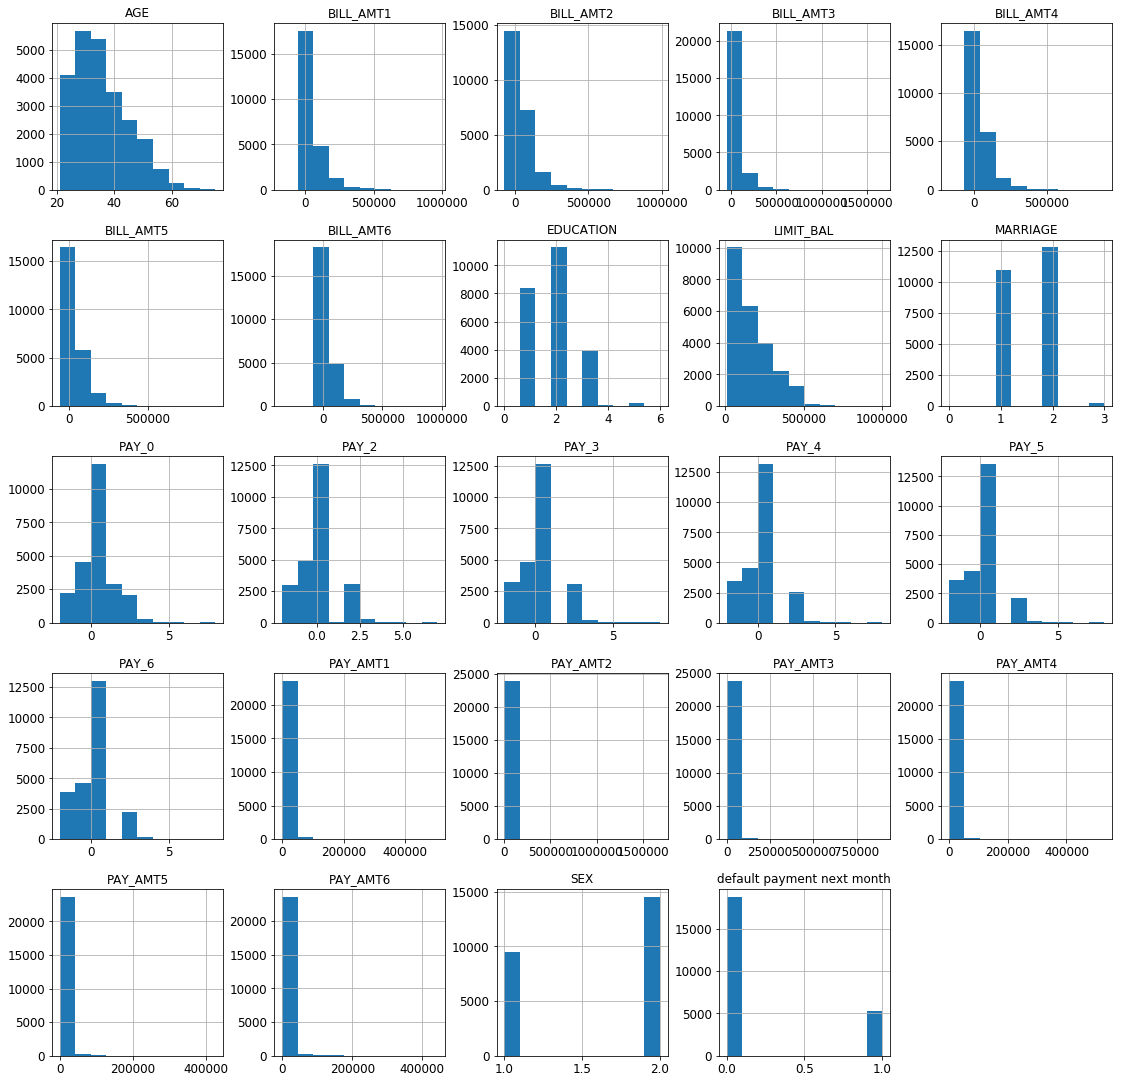

In [6]:
train.hist(figsize=(19,19))

### Insights from the histograms:
<ul>
    <li>PAY_AMTn values should probably be pre-processed somehow.</li>
    <li>Many of these histograms are tail heavy, and should be transformed to have more bell shaped distributions</li>
    <li>Attribute scales vary widely</li>
    <li>Invalid categorical values</li>
    <li>Encoding of categorical values (one-hot encoding) is required</li>
</ul>

In [7]:
# Let's look at the correlation between each of the features with the target
train.corr()['default payment next month'].sort_values(ascending=False)

default payment next month    1.000000
PAY_0                         0.319950
PAY_2                         0.260874
PAY_3                         0.235001
PAY_4                         0.216360
PAY_5                         0.201300
PAY_6                         0.186007
EDUCATION                     0.028532
AGE                           0.018256
BILL_AMT6                    -0.007267
BILL_AMT5                    -0.008974
BILL_AMT4                    -0.011534
BILL_AMT3                    -0.015562
BILL_AMT2                    -0.015636
BILL_AMT1                    -0.021193
MARRIAGE                     -0.028094
SEX                          -0.040731
PAY_AMT6                     -0.052889
PAY_AMT5                     -0.053719
PAY_AMT4                     -0.056046
PAY_AMT3                     -0.057475
PAY_AMT2                     -0.058113
PAY_AMT1                     -0.075747
LIMIT_BAL                    -0.154215
Name: default payment next month, dtype: float64

It seems like for PAY_n, the correlation is stronger with the values the month prior to default, which intuitively makes sense. The greater the delinquency in August 2005, the more likely you are to default in September 2005. We can ignore the other PAY_n attributes accordingly. The same seems to hold true for BILL_AMTn and PAY_AMTn, though in general, their correlations to the target label are much weaker.

# Prepare the Data

According to our data dictionary, we did not expect to see values outside of the range of 1-4 in the EDUCATION attribute, however the minimum value in that column is 0 and the maximum is 6. We did not expect to see the value 0 in MARRIAGE, however it does exist. There are -2 values in the PAY_n attributes that are also not expected. All of these types of data discrepancies will need to be cleaned up before training our model. It is worth nothing that it looks like one of the PAY_n attributes has been mislabelled. PAY_0 should really read PAY_1, to align with the convention used by the other _n attributes. But this is of no consequence to our model.

At this point, we have a fair amount of information about each attribute. We know that we are not missing any values. We know that all of our values are integers. We know that some of our attributes are categorical. The target attribute for this task is "default payment next month". And we know that there is some pre-processing work to be done. No feature engineering is required for this assignment.

## Data Cleaning (filter/encode)
<ul>
    <li>Drop records with unexpected EDUCATION values</li>
    <li>Drop records with unexpected MARRIAGE values</li>
    <li>Drop records with unexpected PAY_n values</li>
    <li>One-Hot Encode EDUCATION</li>
    <li>One-Hot Encode MARRIAGE</li>
    <li>One-Hot Encode SEX</li>
</ul>

In [8]:
def filter_data(data):
    
    # make a copy of the input data
    dfTmp = data.copy()
    
    # create filters for dropping certain records whose values
    # don't align with expectations
    edu = dfTmp.EDUCATION.isin([1, 2, 3, 4])
    mar = dfTmp.MARRIAGE.isin([1, 2, 3])
    p0 = (dfTmp.PAY_0 != -2)
    
    # apply the filters
    dfTmp = dfTmp[edu & mar & p0]
    
    # return the filtered dataframe
    return dfTmp

def encode_data(data):
    
    # make a copy of the input data
    dfTmp = data.copy()
    
    # Convert EDUCATION, MARRIAGE and SEX attributes to pandas categorical variables
    dfTmp['EDUCATION'] = pd.Categorical(dfTmp['EDUCATION'])
    dfTmp['MARRIAGE'] = pd.Categorical(dfTmp['MARRIAGE'])
    dfTmp['SEX'] = pd.Categorical(dfTmp['SEX'])

    # One-hot encode the categorical variables
    dfTmp = pd.concat([dfTmp, pd.get_dummies(dfTmp['EDUCATION'], prefix = 'edu')], axis=1)
    dfTmp = pd.concat([dfTmp, pd.get_dummies(dfTmp['MARRIAGE'], prefix = 'mrg')], axis=1)
    dfTmp = pd.concat([dfTmp, pd.get_dummies(dfTmp['SEX'], prefix = 'sex')], axis=1)
    
    # Return the input dataframe with the dummy variables appended
    return dfTmp


## Feature Scaling (standardize/normalize)
<ul>
    <li>Normalize AGE</li>
    <li>Standardize BILL_AMTn (will likely get dropped in feature selection)</li>
    <li>Standardize LIMIT_BAL</li>
    <li>Normalize PAY_0</li>
    <li>Standardize PAY_AMTn (will likely get dropped in feature selection)</li>
</ul>

In [9]:
from sklearn import preprocessing

def scale_data(data):
    
    # Make a copy of the input with a new sequential index
    dfTmp = data.copy()
            
    # Normalize the AGE and PAY_0 features
    X = dfTmp[['AGE','PAY_0']].astype(dtype='float64').values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    X_scaled = min_max_scaler.fit_transform(X)
    
    # Add the normalized features to the source dataframe, with specified headers and index
    dfScaled = pd.DataFrame(X_scaled, columns = ['nrmAGE', 'nrmPAY_0'], index=dfTmp.index)
    
    # The index for dfScaled would have been 0 to 21537 by default, but I specified the
    # same index as dfTmp, so the new columns would combine correctly.
    dfTmp = pd.concat([dfTmp, dfScaled], axis=1)
    
    # Standardize BILL_AMT1, LIMIT_BAL, PAY_AMT1
    cols = np.array([
                'BILL_AMT1', 'LIMIT_BAL', 'PAY_AMT1'
        ])
    X = dfTmp[cols].values
    X_scaled = preprocessing.scale(X)
    
    # Add the scaled features to the source dataframe.
    # A prefix of "scl" will be pre-pended to the original attribute name to create the new name
    dfScaled2 = pd.DataFrame(X_scaled, columns = np.core.defchararray.add('scl', cols), index=dfTmp.index)
    
    dfTmp = pd.concat([dfTmp, dfScaled2], axis=1)
    
    return dfTmp

In [10]:
df2 = filter_data(train)
df2 = encode_data(df2)
df2 = scale_data(df2)

C:\Users\craig\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


## Feature Selection (drop)

<ul>
    <li>Drop EDUCATION in favor of the related dummy variables</li>
    <li>Drop MARRIAGE in favor of the related dummy variables</li>
    <li>Drop SEX in favor of the related dummy variable</li>
    <li>Drop PAY_0 in favor of the normalized version</li>
    <li>Drop PAY_2 through PAY_6</li>
    <li>Drop BILL_AMT1 in favor of the standardized version</li>
    <li>Drop BILL_AMT2 through BILL_AMT6</li>
    <li>Drop PAY_AMT1 in favor of the standardized version</li>
    <li>Drop PAY_AMT2 through PAY_AMT6</li>
    <li>Drop LIMIT_BAL in favor of the standardized version</li>
    <li>Drop redundant dummy variables (sex_2, mrg_3, edu_4)</li>
</ul>

In [11]:
def select_data(data):
    
    dfTmp = data.copy()
    return dfTmp.drop(columns=['LIMIT_BAL', 'AGE', 'EDUCATION', 'MARRIAGE', 'SEX', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 
                        'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'sex_2', 'mrg_3', 'edu_4'], axis=1)

In [12]:
df2 = select_data(df2)
df2.head()

,default payment next month,edu_1,edu_2,edu_3,mrg_1,mrg_2,sex_1,nrmAGE,nrmPAY_0,sclBILL_AMT1,sclLIMIT_BAL,sclPAY_AMT1
9424,1,1,0,0,0,1,0,0.185185,0.111111,-0.299965,-0.778200,-0.231654
5015,0,1,0,0,0,1,0,0.055556,0.222222,-0.732679,1.027494,-0.359695
4170,0,1,0,0,0,1,1,0.111111,0.000000,-0.553703,-0.150132,0.644661
4838,1,0,1,0,0,1,0,0.018519,0.333333,-0.533693,-0.856708,-0.359695
552,1,1,0,0,1,0,1,0.648148,0.111111,-0.060176,-0.856708,-0.199644


# Short-List Promising Models / Fine-Tune the System

The idea here is to train multiple models using standard parameters, and measure and compare their performance. Use N-fold cross-validation and compute the mean and standard deviation of the performance measure (roc_auc in our case) on the N folds. Further anaylsis can be done to support another quick round of feature engineering/feature selection before deciding on the which models are most promising and should be explored further.

For the purpose of this assignment, we have only been asked to train the following 2 classifiers:

<ol>
    <li>kNN Classifier</li>
    <li>Random Forest Classifier</li>
</ol>
    
We will use both 4-fold cross validation and 5-fold cross validation and compare the performance of both scenarios. Normally, hyper-parameter tuning occurs in a separate fine-tuning phase, but since there are only 2 models being considered, we will bundle that task, and the model testing, into this combined phase.

In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

def summ_scores(s):
    print('The mean score is {:1.3}'.format(np.mean(s)))
    print('The standard deviation is {:1.3}'.format(np.std(s)))
    return

X = df2.drop(['default payment next month'], axis=1).values
y = df2['default payment next month'].values

knn = KNeighborsClassifier()
param_grid = {'n_neighbors': [3, 4, 5, 7, 10, 20, 50]}

clf = GridSearchCV(knn, param_grid, cv=5)
clf.fit(X, y)
print(clf.best_params_)

print('4-folds cross-validation:')
scores = cross_val_score(clf, X, y, cv=4, scoring='roc_auc')
summ_scores(scores)

print('5-folds cross-validation:')
scores = cross_val_score(clf, X, y, cv=5, scoring='roc_auc')
summ_scores(scores)

C:\Users\craig\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


{'n_neighbors': 20}
4-folds cross-validation:
The mean score is 0.682
The standard deviation is 0.0108
5-folds cross-validation:
The mean score is 0.691
The standard deviation is 0.00667


In [14]:
# Let's try the random forest classifier
rfc = RandomForestClassifier()
param_grid = {'n_estimators': [3, 4, 6, 7, 10, 20, 50, 100]}

clf2 = GridSearchCV(rfc, param_grid, cv=5)
clf2.fit(X, y)
print(clf2.best_params_)

print('4-folds cross-validation:')
scores = cross_val_score(clf2, X, y, cv=4, scoring='roc_auc')
summ_scores(scores)

print('5-folds cross-validation:')
scores = cross_val_score(clf2, X, y, cv=5, scoring='roc_auc')
summ_scores(scores)

{'n_estimators': 100}
4-folds cross-validation:
The mean score is 0.735
The standard deviation is 0.00987
5-folds cross-validation:
The mean score is 0.739
The standard deviation is 0.007


In [15]:
# There is a marginal improvement between 4-folds cross-validation and
# 5-folds cross-validation for either model. We'll stick with 5-folds.
# The random forest classifier is obviously doing a better job than kNN.
print(clf2.best_estimator_.feature_importances_)

[0.01011966 0.01167016 0.01000058 0.00984403 0.00941365 0.0201717
 0.1744455  0.17489315 0.24592698 0.1418304  0.1916842 ]


In [16]:
# The above result tells us that our dummy variables for education, marriage and sex are all relatively unimportant.
# Let's drop those features and see if we can improve our result.

X2 = X[:,6:]
clf2.fit(X2, y)
print(clf2.best_params_)

scores = cross_val_score(clf2, X2, y, cv=5, scoring='roc_auc')
summ_scores(scores)

{'n_estimators': 100}
The mean score is 0.73
The standard deviation is 0.00488


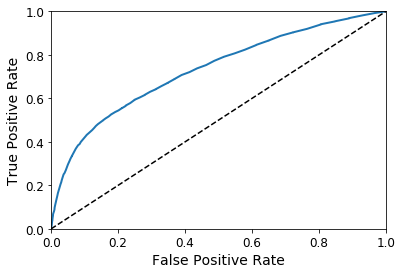

In [17]:
# The added feature selection step didn't make a big difference to the performance of the model,
# but at the very least, it simplied it.
# Let's look at the ROC curve of the selected model
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict

# Function plot_roc_curve() taken from our text book
# Hands-On Machine Learning with Scikit-Learn & TensorFlow, Aurelien Geron, p. 93
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

y_probas_forest = cross_val_predict(clf2, X2, y, cv=5, method='predict_proba')
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y, y_scores_forest)

plot_roc_curve(fpr_forest, tpr_forest)
plt.show()

When picking a threshold, we look for points closest to the upper left-hand corner of the ROC box. In this case, it would be where the TPR is somewhere between 0.5 and 0.6. This would maximize the true positive rate, while minimizing the false positive rate.

We have selected the model which uses a Random Forest Classifier as its estimator. The last thing we need to do is to run this model against our test set, to ensure that the model generalizes well. We need to apply our pre-processing steps to the test set before running the model:

In [18]:
df3 = filter_data(test)
df3 = encode_data(df3)
df3 = scale_data(df3)
df3 = select_data(df3)

X_test = df3.drop(['default payment next month'], axis=1).values
y_test = df3['default payment next month'].values

rfc_test = RandomForestClassifier(n_estimators=100)
rfc_test.fit(X_test, y_test)

scores = cross_val_score(rfc_test, X_test, y_test, cv=5, scoring='roc_auc')
summ_scores(scores)

C:\Users\craig\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


The mean score is 0.741
The standard deviation is 0.00675


# Present Your Solution

The entirety of the analysis is documented within this Jupyter notebook. The solution presented achieves the business objective, as our model has predictive ability when it comes to determining whether a credit-card customer will go into default. However, in a business context, we would probably expect much higher performance before we would consider operationalizing the model. Interesting observations have been noted inline with the analysis itself. Key findings are described in the Conclusions section below.

# Launch

We have no production inputs to plug into this model or for retraining, nor is there any need to monitor its performance. These are steps we would expect to take in a real-world exercise, but are outside the scope of this assignment.

#### Conclusions?

Explain your results and choices

We can draw a number of conclusions from the analysis above:

<ol>
    <li>A customer's level of education, marital status or sex is not indicative of whether they are likely to default on their credit card payments.</li>
    <li>Age, missed payment history, credit limit and account balance all are important factors in determining whether a customer is likely to default on their credit card payments.</li>
    <li>Our stated purpose for this analysis (see Frame the Problem section) was to compare the performance of kNN with a Random Forest Classifier. Per the ROC AUC metric, the Random Forest Classifier was a better ML algorithm for this model.</li>
    <li>Our model generalizes well, as it actually performed a bit better against the test set, than it did in cross-validation.</li>
</ol>

Q2. (Optional) Write a function that can shift an MNIST image in any direction (left, right, up, or down) by one pixel. Then, for each image in the training set, create four shifted copies (one per direction) and add them to the training set. Finally, train your best model on this expanded training set and measure its accuracy on the test set. You should observe that your model performs even better now! This technique of artificially growing the training set is called data augmentation or training set expansion. 

In [19]:
# Shifts an MNIST image in any specified direction by one pixel.
def shift_by_one(image, direction):

    if direction.lower() == 'right':
        a = np.delete(image, 27, 1)
        a = np.insert(a, 0, 0, 1)
        return a
    elif direction.lower() == 'left':
        a = np.delete(image, 0, 1)
        a = np.insert(a, 27, 0, 1)
        return a
    elif direction.lower() == 'up':
        a = np.delete(image, 0, 0)
        a = np.insert(a, 27, 0, 0)
        return a
    elif direction.lower() == 'down':
        a = np.delete(image, 27, 0)
        a = np.insert(a, 0, 0, 0)
        return a
    else:
        print('Invalid direction: ' + direction)
        return None

In [20]:
def enhance_training_set(X_train, y_train):
    
    enhancedX = np.copy(X_train)
    enhancedY = np.copy(Y_train)
    
    # For each image, create 4 additional corresponding images and the associated label
    for image, label in X_train, Y_train:
        
        enhancedX.append(shift_by_one(image,'up'))
        enhancedY.append(label)
        
        enhancedX.append(shift_by_one(image,'down'))
        enhancedY.append(label)
        
        enhancedX.append(shift_by_one(image,'left'))
        enhancedY.append(label)
        
        enhancedX.append(shift_by_one(image,'right'))
        enhancedY.append(label)
        
    return enhancedX, enhancedY

### Conclusions


enhance_training_set() can be used to augment the training set from the MNIST database. The augmented training set can then be used to train a classifier, and its performance should exceed that of the model that was trained on the original training set.